## packages and imports

In [1]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import time
from pathlib import Path
import h5py

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)

# trunk network parameters
num_bases = 10
num_trunk_epochs = 100000
lr = 1e-3
num_LBFGS_epochs = 10000
#t_stride = 1
eps = 1e-8 # to prevent loss overflow



print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



W0000 00:00:1769453831.984622 18479716 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1769453832.008725 18479716 service.cc:145] XLA service 0x16a55f800 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769453832.008741 18479716 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1769453832.010265 18479716 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1769453832.010276 18479716 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


In [2]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [3]:
def read_pdebench_h5(
    h5_path: str | Path,
    max_samples: int | None = None,
    channel: int = 0,
):
    """
    Returns:
      t_grid: (T,)
      x_grid: (X,)
      y_grid: (Y,)
      u:      (N, u_dim)  (dummy zeros by default)
      s:      (N, T, X, Y)
    """
    h5_path = Path(h5_path)
    with h5py.File(h5_path, "r") as f:
        sample_keys = sorted(list(f.keys()))
        if max_samples is not None:
            sample_keys = sample_keys[:max_samples]

        # Use first sample to infer grid + shapes
        g0 = f[sample_keys[0]]

        # Read grid
        grid_obj = g0["grid"]
        if isinstance(grid_obj, h5py.Group):
            # expect datasets t,x,y
            keys = list(grid_obj.keys())
            if not all(k in keys for k in ["t", "x", "y"]):
                raise ValueError(f"grid group missing t/x/y datasets; has keys={keys}")
            t_grid = np.asarray(grid_obj["t"])
            x_grid = np.asarray(grid_obj["x"])
            y_grid = np.asarray(grid_obj["y"])
        else:
            # dense mesh stored as dataset
            mesh = np.asarray(grid_obj)
            t_grid, x_grid, y_grid = _grid_from_dense_mesh(mesh)

        # Read data for all samples
        s_list = []
        for k in sample_keys:
            grp = f[k]
            data = np.asarray(grp["data"])

            # Accept (T,X,Y) or (T,X,Y,C)
            if data.ndim == 3:
                field = data
            elif data.ndim == 4:
                if channel < 0 or channel >= data.shape[-1]:
                    raise ValueError(f"channel={channel} out of range for data.shape={data.shape}")
                field = data[..., channel]
            else:
                raise ValueError(f"Unsupported data shape {data.shape} in sample {k}")

            # Ensure ordering is (T,X,Y)
            # If yours is (T,Y,X), swap here after checking against grid lengths.
            T, X, Y = field.shape
            if len(t_grid) != T or len(x_grid) != X or len(y_grid) != Y:
                raise ValueError(
                    f"Grid lengths don't match data shape in sample {k}: "
                    f"len(t)={len(t_grid)}, len(x)={len(x_grid)}, len(y)={len(y_grid)} "
                    f"vs data(T,X,Y)={field.shape}"
                )

            s_list.append(field.astype(np.float32))

        s = np.stack(s_list, axis=0)  # (N,T,X,Y)

    # Dummy params (since many PDEBench files are NA/NA)
    # If you later find actual parameters/ICs, replace this.
    u_dim = 1
    u = np.zeros((s.shape[0], u_dim), dtype=np.float32)

    return (
        jnp.array(t_grid, dtype=jnp.float32),
        jnp.array(x_grid, dtype=jnp.float32),
        jnp.array(y_grid, dtype=jnp.float32),
        jnp.array(u, dtype=jnp.float32),
        jnp.array(s, dtype=jnp.float32),
    )


def eval_trunk_on_grid(trunk_model: MLP, t_grid, x_grid, y_grid):
    """
    Returns T_MAT of shape (T, X, Y, K) where K=num_bases.
    trunk input is [x, y, t].
    """
    def eval_one_t(t):
        # (X,Y,K)
        return jax.vmap(
            lambda x: jax.vmap(
                lambda y: trunk_model(jnp.stack([x, y, t]))
            )(y_grid)
        )(x_grid)

    T_MAT = jax.vmap(eval_one_t)(t_grid)  # (T,X,Y,K)
    return T_MAT


In [4]:
# load external dataset
seed = 42
np.random.seed(seed)
key = jax.random.key(seed)

jax.config.update("jax_platform_name", "metal")
print("backend:", jax.default_backend(), "devices:", jax.devices())

# ---- load PDEBench H5 ----
h5_path = "/Users/haydenoutlaw/Documents/Research/opnet/PDEBench/data/2D_rdb_NA_NA/2D_rdb_NA_NA.h5"
t_grid, x_grid, y_grid, u, s = read_pdebench_h5(h5_path, max_samples=None, channel=0)
print("t,x,y:", t_grid.shape, x_grid.shape, y_grid.shape)
print("u:", u.shape, "s:", s.shape)  # s is (N,T,X,Y)

# ---- train/test split ----
n_samp = s.shape[0]
train_idx, test_idx = train_test_split(np.arange(n_samp), test_size=0.2, random_state=seed)

u_train, u_test = u[train_idx], u[test_idx]
s_train, s_test = s[train_idx], s[test_idx]

# output_tr: (T,X,Y,N)
output_tr = jnp.transpose(s_train, (1, 2, 3, 0))
print("output_tr:", output_tr.shape)



backend: METAL devices: [METAL(id=0)]


: 

In [ ]:
#u_train, s_train = u,s
print('label dataset size is (n, coord) = ', u_train.shape)
print('input dataset size is (n, x, t) = ', s_train.shape)

output_tr = jnp.transpose(s_train, axes=(1,2,0)) 
print(f"subsampled dataset size is (t,x,n) = {output_tr.shape}")

label dataset size is (n, coord) =  (352, 2)
input dataset size is (n, x, t) =  (352, 201, 201)
subsampled dataset size is (t,x,n) = (201, 201, 352)


In [ ]:
tt,xx = jnp.meshgrid(t_grid, x_grid)
tx_grid = jnp.concatenate([tt.flatten()[:,None], xx.flatten()[:,None]], axis=1) #xt_grid[:,1] is x, xt_grid[:,0] is t
print("tx_grid is of shape (n, coord) = ",tx_grid.shape)

tx_grid is of shape (n, coord) =  (40401, 2)


## initializing model, loss_fn

In [ ]:
num_bases = 10
num_epochs = 20000
lr = 1e-3
eps = 1e-8

y_dim = 3  # (x,y,t)
trunk_arch = [y_dim, 40, 40, num_bases]

key, subkey_t, subkey_A = jax.random.split(key, 3)
trunk_model = MLP(trunk_arch, key=subkey_t)

# time-dependent coefficients A(t) for each sample
# A_model: (T, K, Ntrain)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, output_tr.shape[-1]), dtype=jnp.float32)

model = (trunk_model, A_model)

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = eval_trunk_on_grid(trunk_model, t_grid, x_grid, y_grid)  # (T,X,Y,K)
    pred = jnp.einsum("txyk,tkn->txyn", T_MAT, A_model)              # (T,X,Y,N)
    return jnp.mean((output_tr - pred) ** 2) / (jnp.mean(output_tr ** 2) + eps)

opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


A_model is shape (t, num_bases, num_samples) =  (201, 10, 352)


In [ ]:
%%time
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
t0 = time.time()
last = time.time()
for step in range(num_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss))
    if step % 20 == 0:
        now = time.time()
        print(f"\rstep {step}: loss={float(loss):.3e}  dt={now-last:.2f}s", end="", flush=True)
        last = now
print(f"\nfinal loss={float(loss):.3e}  total={time.time()-t0:.1f}s")




(201, 201, 10) (201, 10, 352)
Adam step 99990: loss=3.422e-05, 0.12s
final adam loss: 3.542e-05, total time: 1371.29s

LBFGS step 9900: loss=2.176e-05                                                 CPU times: user 5min 18s, sys: 1min 21s, total: 6min 39s
Wall time: 25min 1s


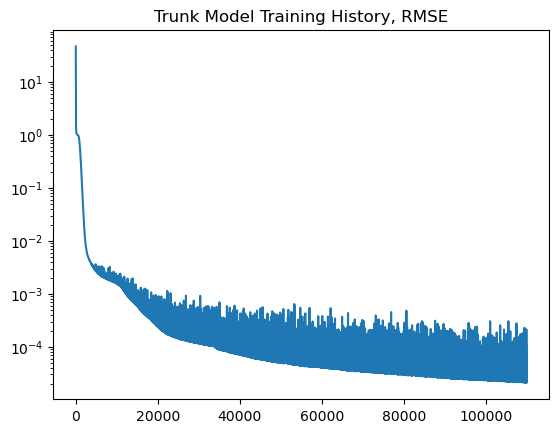

In [ ]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, RMSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [ ]:
trunk_model, A_model = model
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)

T_MAT is shape (t,x,n) =  (201, 201, 10)


In [ ]:
# for index i of t_grid (subsampled here every 2)
 trunk_model, A_model = model
    T_MAT = eval_trunk_on_grid(trunk_model, t_grid, x_grid, y_grid)  # (T,X,Y,K)
    T_np = np.array(T_MAT)

    T_len, X_len, Y_len, K = T_np.shape
    Q_list = []
    R_list = []
    for ti in range(T_len):
        M = T_np[ti].reshape(X_len * Y_len, K)       # (XY,K)
        Q, R = scipy.linalg.qr(M, mode="economic")   # Q: (XY,K), R: (K,K)
        Q_list.append(Q.reshape(X_len, Y_len, K))
        R_list.append(R)

    Q_MAT = np.stack(Q_list, axis=0)  # (T,X,Y,K)
    R_MAT = np.stack(R_list, axis=0)  # (T,K,K)

    # sign continuity correction across time (per basis column)
    Q_sign = Q_MAT.copy()
    R_sign = R_MAT.copy()
    for ti in range(1, T_len):
        for k in range(K):
            # dot over spatial grid
            prev = Q_sign[ti - 1, :, :, k].reshape(-1)
            curr = Q_sign[ti, :, :, k].reshape(-1)
            if np.dot(prev, curr) < 0:
                Q_sign[ti, :, :, k] *= -1
                R_sign[ti, k, :] *= -1

    # save factors for branch stage
    save_path = Path("qr_factors_2d_cont.npz")
    np.savez_compressed(
        save_path,
        Q=Q_sign.astype(np.float32),
        R=R_sign.astype(np.float32),
        t_grid=np.array(t_grid),
        x_grid=np.array(x_grid),
        y_grid=np.array(y_grid),
    )
    print("saved:", save_path)


Q_MAT is of shape (t,x,n) = (201, 201, 10)
R_MAT is of shape (201, 10, 10)
shapes agree? True


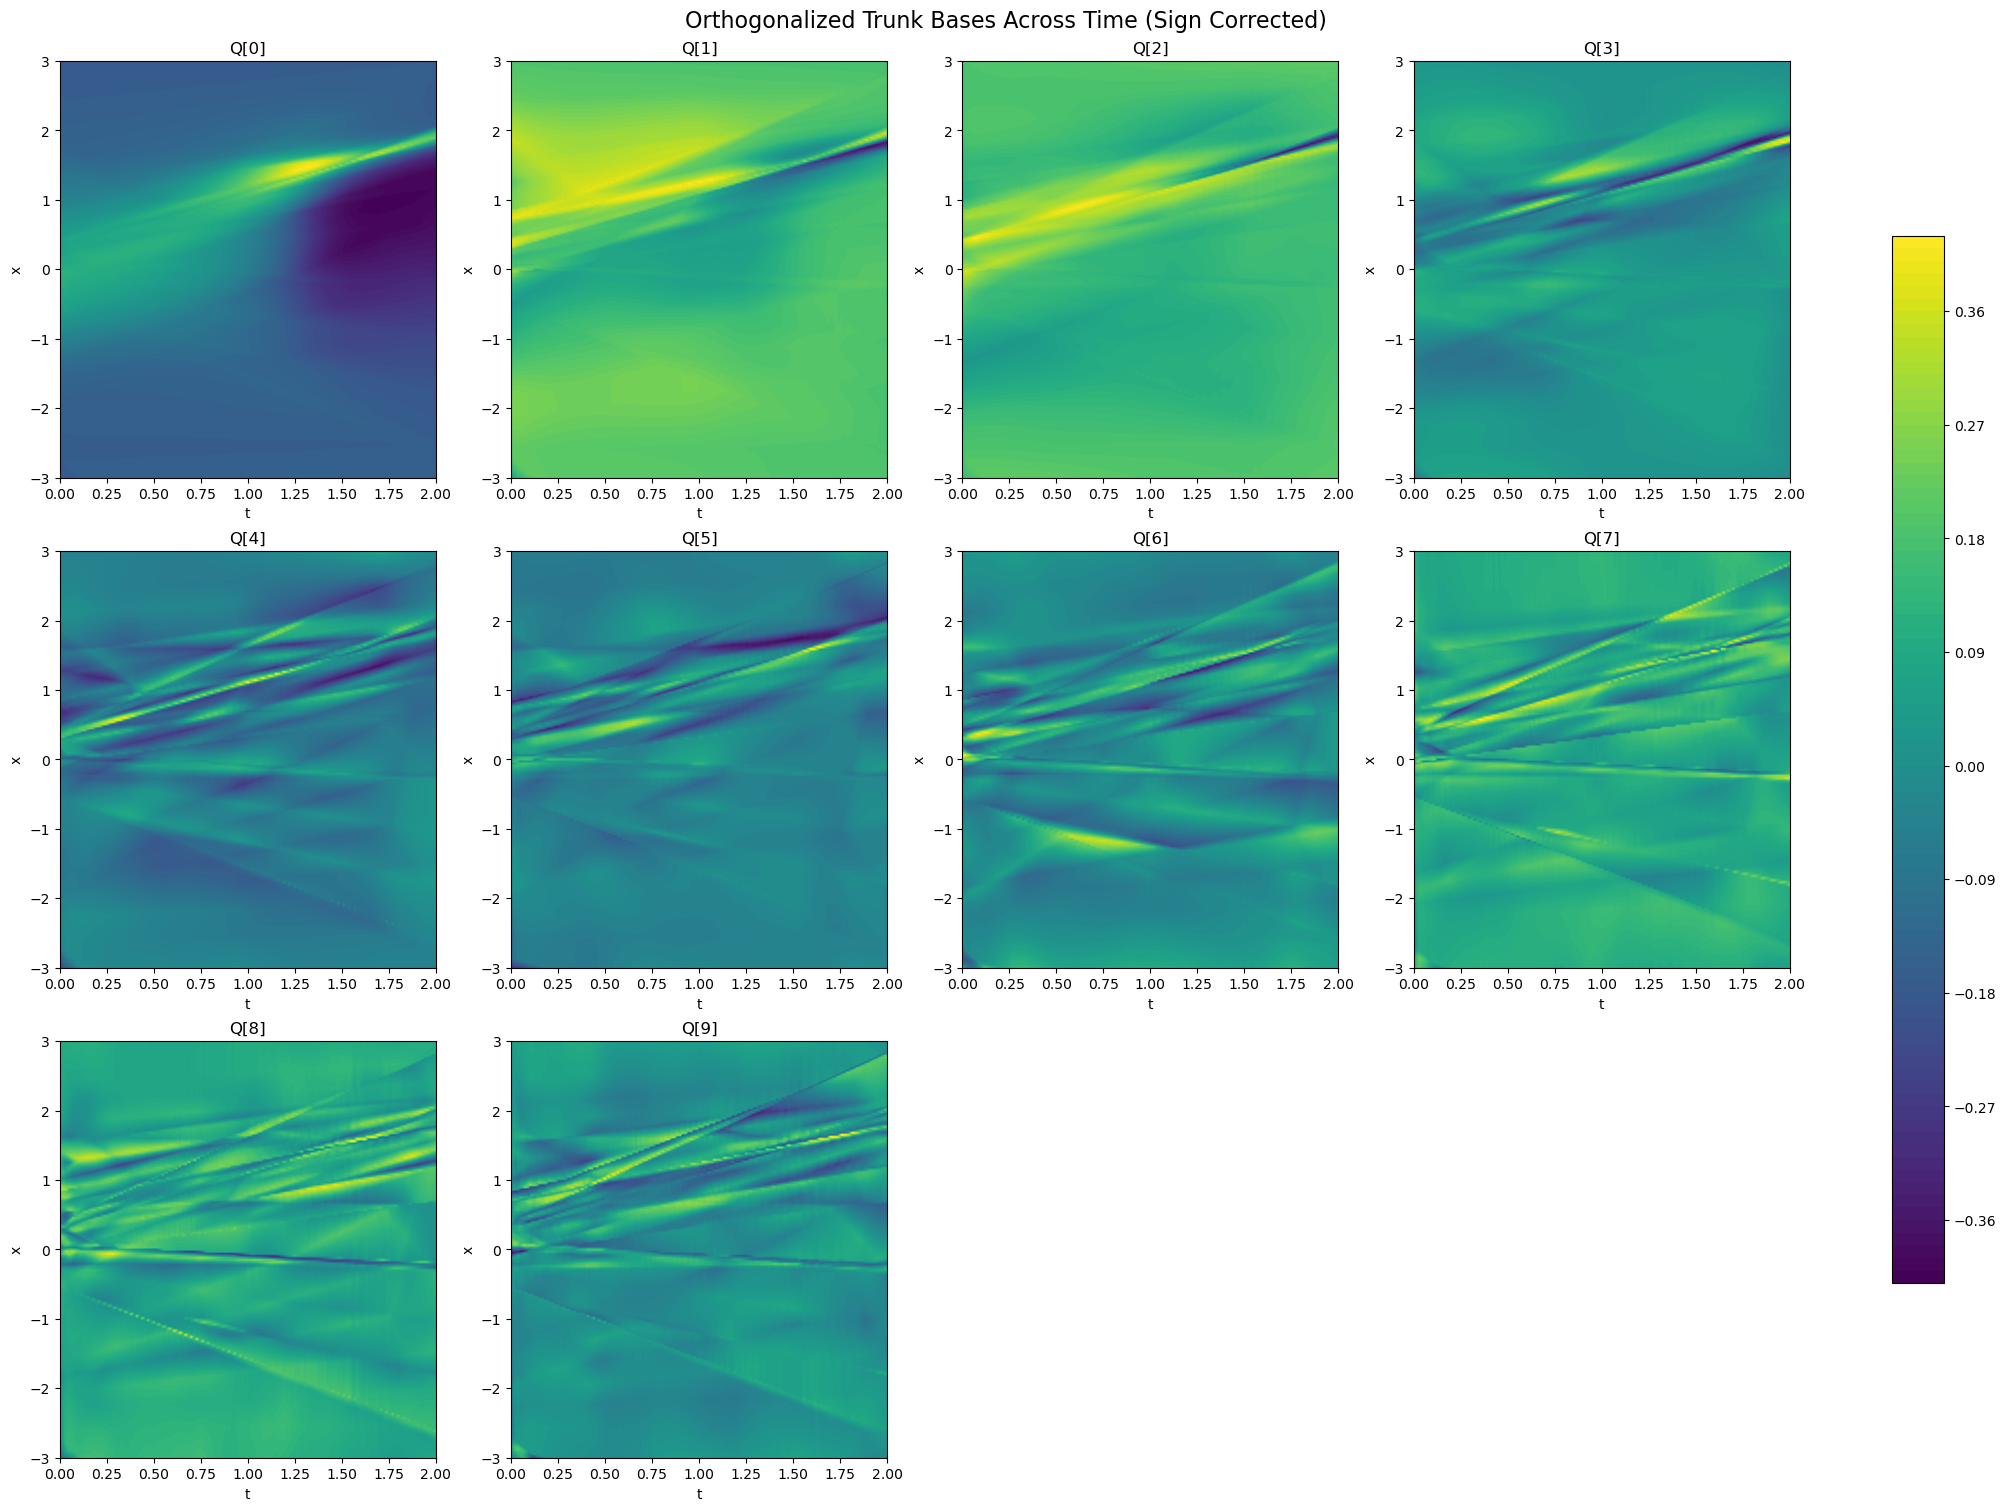

In [ ]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    constrained_layout=True
)

axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_sign[:, :, k]

        # 2D top-down plot
        im = ax.contourf(T, X, Q_k, levels=100, cmap='viridis')

        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(
    f"Orthogonalized Trunk Bases Across Time (Sign Corrected)",
    fontsize=16
)

# attach a single colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.75)

plt.show()


## save out Q,R factors and data

In [ ]:
save_path = Path("qr_factors_cont.npz")

# export data to .npz arrays
np.savez_compressed(
    save_path,
    Q = np.asarray(Q_sign),
    R = np.asarray(R_sign),
    t_grid = np.asarray(t_grid),
    x_grid = np.asarray(x_grid)
)

print("exported to:", save_path)

exported to: qr_factors_cont.npz


## .gif renders

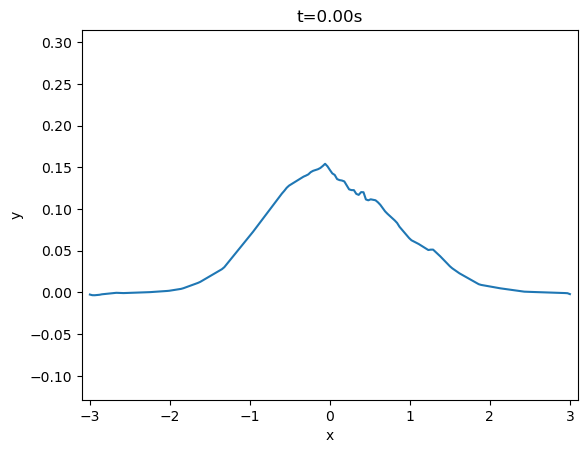

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

basis_idx = 0
fig, ax = plt.subplots()
line2 = ax.plot(x_grid,Q_sign[0,:,basis_idx])[0]
vmin, vmax = jnp.min(Q_sign[:,:,basis_idx]), jnp.max(Q_sign[:,:,basis_idx])
ax.set(xlim=[-3.1, 3.1], ylim=[vmin, vmax], xlabel='x', ylabel='y')
# ax.legend()

def update(frame):
    line2.set_xdata(x_grid)
    line2.set_ydata(Q_sign[frame,:,basis_idx])
    # update the title:
    ax.set_title(f't={t_grid[frame]:.2f}s')
    return line2

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(t_grid) -1 , interval=50)
ani.save(filename=f"DON_basis_{basis_idx}.gif", writer="pillow")

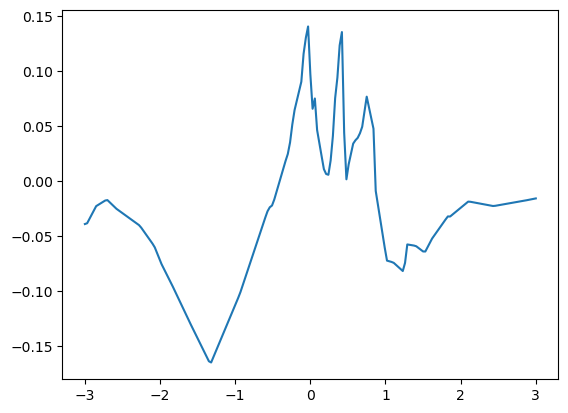

In [ ]:
plt.plot(x_grid,Q_MAT[1,:,2])[0]

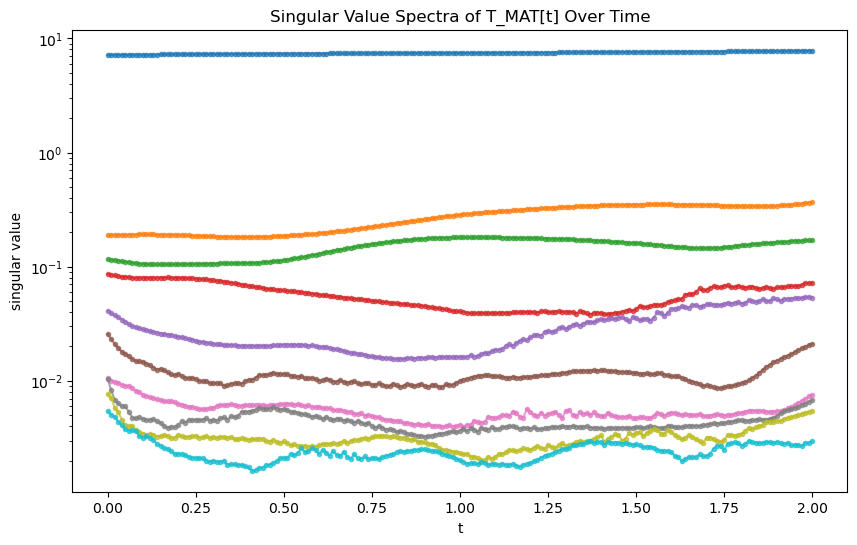

In [ ]:
num_times = T_MAT.shape[0]

# compute SVD spectra at all times
sv_list = []
for i in range(num_times):
    _, S, _ = scipy.linalg.svd(np.array(T_MAT[i]), full_matrices=False)
    sv_list.append(S)

sv_array = np.vstack(sv_list)   # shape (t, num_bases)

plt.figure(figsize=(10,6))

for k in range(sv_array.shape[1]):
    plt.plot(t_grid, sv_array[:, k], '.-', alpha=0.7)

plt.yscale('log')
plt.xlabel("t")
plt.ylabel("singular value")
plt.title("Singular Value Spectra of T_MAT[t] Over Time")
#plt.grid(True, which='both', ls='--', alpha=0.3)

plt.show()

In [ ]:
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
print(T_MAT.shape, A_model.shape)
pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model)

(201, 201, 10) (201, 10, 352)


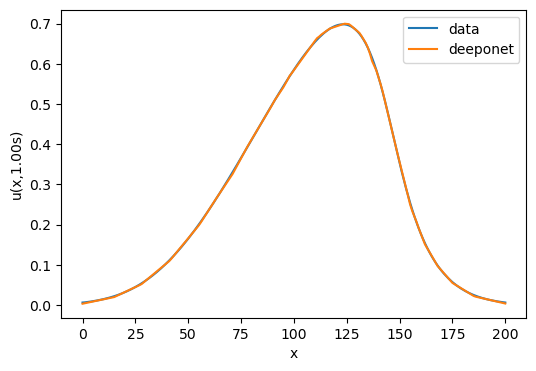

In [ ]:
j= 100
idx_param = 20
# print(T.shape, X.shape, pred_y[:,:,0] - output_tr[:,:,0])
plt.figure(figsize=(6,4))
plt.plot(output_tr[j,:,idx_param], label='data')
plt.plot(pred_y[j,:,idx_param], label='deeponet')
plt.xlabel("x")
plt.ylabel(f"u(x,{t_grid[j]:.2f}s)")
plt.legend()
# plt.title("u(t, x)")
# plt.colorbar(label="u")
plt.show()


## branch network training

In [ ]:
K = A_model.shape[1] # number of basis functions
N = A_model.shape[2] # number of systems 


# define architectures for component networks
branch_arch = [u_train.shape[1] + 1, 40, 40, K] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
branch_model = MLP(branch_arch,key = subkey_t)

print(Q_sign.shape) # Q is (201,201,10) = (t,x,basis)


B_tnk = jax.vmap(
    lambda t: jax.vmap(
        lambda u: branch_model(jnp.concatenate([u, jnp.array([t])]))
    )(u_train)   # u_train shape (N,2)
)(t_grid)        # (T,N,K)

B_MAT = jnp.swapaxes(B_tnk, 1, 2)  # (T, K, N)


print("Branch Model is shape:", B_MAT.shape)


print("R Tensor is shape  (t, trunk #, trunk #) =", R_sign.shape) # R is t, N, N
print("A Tensor is shape (t, trunk #, n) =", A_model.shape) # A is t, basis idx, n


RA_model = jnp.einsum("tij, tjk -> tik", R_sign, A_model) ## IS THIS LOGIC RIGHT??
print("RA Tensor is shape:", RA_model.shape)


(201, 201, 10)
Branch Model is shape: (201, 10, 352)
R Tensor is shape  (t, trunk #, trunk #) = (201, 10, 10)
A Tensor is shape (t, trunk #, n) = (201, 10, 352)
RA Tensor is shape: (201, 10, 352)


In [ ]:

RA_target = jnp.asarray(RA_model)  # (T, K, N), frozen data

def branch_loss_fn(branch_model, RA_target, u_train, t_grid, eps=1e-8): # vmap u_train (parameters) and t_grid through branch model -- loss is B_NN - R^*A^*
    B_tnK = jax.vmap(
        lambda t: jax.vmap(
            lambda u: branch_model(jnp.concatenate([u, jnp.array([t])]))
        )(u_train)
    )(t_grid)  # (T, N, K)

    B_MAT = jnp.swapaxes(B_tnK, 1, 2)  # (T, K, N) # does require an internal tensor transpose
    return jnp.mean((B_MAT - RA_target) ** 2) / (jnp.mean(B_MAT ** 2) + eps)

# ---- optimizer ----
opt = optax.adam(lr)

# IMPORTANT: init on branch_model only
opt_state = opt.init(eqx.filter(branch_model, eqx.is_inexact_array))

@eqx.filter_jit # does require filter value and grad because of frozen RA target
def branch_train_step(branch_model, opt_state, RA_target, u_train, t_grid):
    loss, grads = eqx.filter_value_and_grad(branch_loss_fn)( 
        branch_model, RA_target, u_train, t_grid
    )
    updates, opt_state = opt.update(grads, opt_state, branch_model)
    branch_model = eqx.apply_updates(branch_model, updates)
    return branch_model, opt_state, loss



In [ ]:
%%time
#---- training loop ----
branch_loss_hist = []


for step in range(num_trunk_epochs):
    branch_model, opt_state, loss = branch_train_step(
        branch_model, opt_state, RA_target, u_train, t_grid
    )
    branch_loss_hist.append(float(loss))
    if step % 10 == 0:
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}",
              end="", flush=True)

print(f"\nfinal adam loss: {float(loss):.3e}\n")

Adam step 99990: loss=1.036e-04
final adam loss: 1.003e-04

CPU times: user 6min 31s, sys: 1min 30s, total: 8min 2s
Wall time: 21min 59s


In [ ]:
u_rand, s_rand = u_train[20], s_train[20] # s is true values, u is input parameters

def branch_over_time(branch_model, u, t_grid):
    # u: (u_dim,), t_grid: (T,), returns (T, K)
    return jax.vmap(lambda t: branch_model(jnp.concatenate([u, jnp.array([t])])))(t_grid)

def compute_QHb_grid(Q_sign, branch_model, u, t_grid):
    """
    Q_sign: (T, X, K)  storing Q(t,x,k)
    u:      (u_dim,)
    returns: (T, X) with entries sum_k conj(Q[t,x,k]) * b[t,k]
    """
    b_tk = branch_over_time(branch_model, u, t_grid)          # (T, K)
    grid_tx = jnp.einsum("txk,tk->tx", jnp.conj(Q_sign), b_tk)  # (T, X)
    return grid_tx

rand_pred_tx = compute_QHb_grid(Q_sign, branch_model, jnp.array(u_rand), jnp.array(t_grid))
print(rand_pred_tx.shape)  # (T, X)

(201, 201)


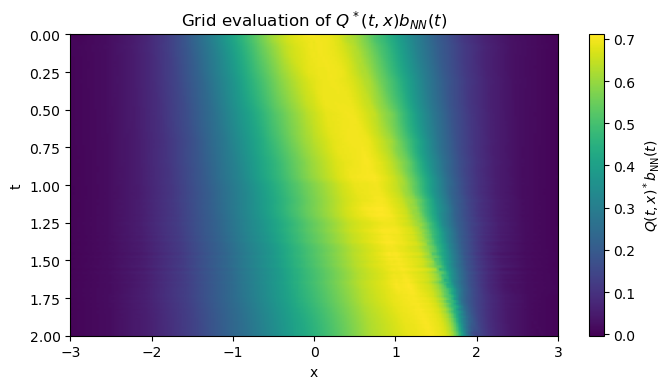

In [ ]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $Q^*(t,x)b_{NN}(t)$")
plt.tight_layout()
plt.show()


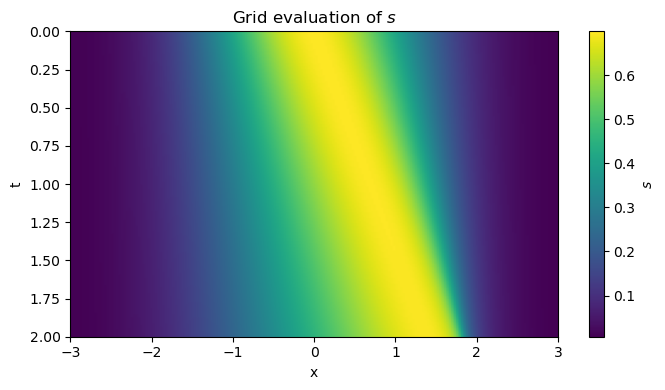

In [ ]:
plt.figure(figsize=(7, 4))
plt.imshow(
    s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$s$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Grid evaluation of $s$")
plt.tight_layout()
plt.show()


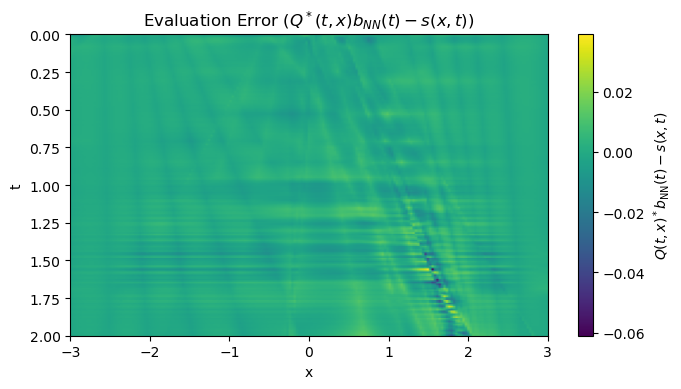

In [ ]:
plt.figure(figsize=(7, 4))
plt.imshow(
    rand_pred_tx - s_rand,
    extent=[x_grid[0], x_grid[-1], t_grid[-1], t_grid[0]],
    aspect="auto",
    origin="upper"
)
plt.colorbar(label=r"$Q(t,x)^* b_{\mathrm{NN}}(t) - s(x,t)$")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Evaluation Error ($Q^*(t,x)b_{NN}(t) - s(x,t)$)")
plt.tight_layout()
plt.show()
